In this notebook we are going through steps to setup a simple chess board AI.

In [47]:
%pip install chess

Note: you may need to restart the kernel to use updated packages.


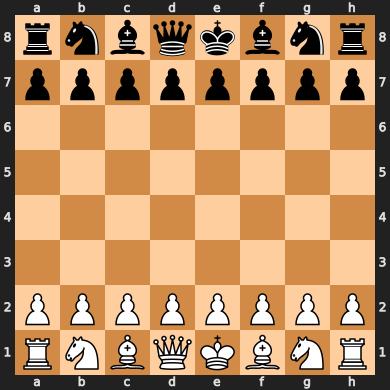

In [48]:
import chess

board = chess.Board()
# Simple chess board for functioning my AI
board

We can use this for our agents playground. Time to setup the ground truth

In [49]:
%pip install stockfish

Note: you may need to restart the kernel to use updated packages.


Now we have the opponent to test ground truth.
For making an AlphaZero model, we will need it in the very late stage - when the model is almost done.

In [50]:
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [51]:
import numpy as np

# We build the ChessState for AlphaZero to evaluate first
class ChessState:
    def __init__(self, board: chess.Board):
        self.board = board

    def clone(self):
        return ChessState(self.board.copy())

    def apply_move(self, move: chess.Move):
        self.board.push(move)

    def is_terminal(self):
        return self.board.is_game_over()

    def legal_moves(self):
        return list(self.board.legal_moves)

    def result(self):
        return self.board.result()

Next we focus on Deep Neural Network
This network focus on learning the probability of the next move -> the policy of the game, the value for the current player -> the game ultimate winner following this move

Input (C, 8, 8) (game state)
↓
Conv Layer (Conv 3x3 x 256, BN, ReLU)
↓
Residual Layer × N (Conv 3x3 x 256, BN, ReLU, Conv 3x3 x 256, BN, Skip Connection, ReLU) # This skip is important to help model learn, avoid desc grad
↓
↓-------------------↓
|                   |
Policy Head         Value Head
Conv 1×1 x 2        Conv 1×1
BN, ReLU            BN, ReLU
FC (to 4672)        FC (hidden, 256) → ReLU → FC (1) → tanh

Now there might be some confoosion (kinda) around 4672.
4672 = 8x8x73
= 8x8 x (56 directional offsets + 8 knight moves + 9 promotions)
Now you may be more CONFOOSION, extra promotion just dropped out of somewhere
This is for strong model to learn underpromotion.

In [52]:
%pip install torch
%pip install h5py

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [53]:
# Let's just jump directly into making layers
import torch
import torch.nn as nn
import torch.nn.functional as F
import functools
import h5py
import os

# Input Convolutional Layer
class InputConvolutionalLayer(nn.Module):
    def __init__(self, in_channels=103, out_channels=256):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
    
    def load_from_hdf5(self, h5_group):
        self.conv.weight.data = torch.tensor(h5_group['conv_weight'][:])
        self.conv.bias.data = torch.tensor(h5_group['conv_bias'][:])
        self.bn.weight.data = torch.tensor(h5_group['bn_weight'][:])
        self.bn.bias.data = torch.tensor(h5_group['bn_bias'][:])
        self.bn.running_mean.data = torch.tensor(h5_group['bn_running_mean'][:])
        self.bn.running_var.data = torch.tensor(h5_group['bn_running_var'][:])
    
# Residual Layer
class ResidualLayer(nn.Module):
    def __init__(self, channels=256):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2= nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2= nn.BatchNorm2d(num_features=channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        residual = self.conv1(residual)
        residual = self.bn1(residual)
        residual = self.relu1(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)
        residual = residual + x
        residual = self.relu2(residual)
        return residual
    
    def load_from_hdf5(self, h5_group):
        self.conv1.weight.data = torch.tensor(h5_group['conv1_weight'][:])
        self.conv1.bias.data = torch.tensor(h5_group['conv1_bias'][:])
        self.bn1.weight.data = torch.tensor(h5_group['bn1_weight'][:])
        self.bn1.bias.data = torch.tensor(h5_group['bn1_bias'][:])
        self.bn1.running_mean.data = torch.tensor(h5_group['bn1_running_mean'][:])
        self.bn1.running_var.data = torch.tensor(h5_group['bn1_running_var'][:])
        self.conv2.weight.data = torch.tensor(h5_group['conv2_weight'][:])
        self.conv2.bias.data = torch.tensor(h5_group['conv2_bias'][:])
        self.bn2.weight.data = torch.tensor(h5_group['bn2_weight'][:])
        self.bn2.bias.data = torch.tensor(h5_group['bn2_bias'][:])
        self.bn2.running_mean.data = torch.tensor(h5_group['bn2_running_mean'][:])
        self.bn2.running_var.data = torch.tensor(h5_group['bn2_running_var'][:])

# Value Head
class ValueHead(nn.Module):
    def __init__(self, in_channels, hidden_size):
        super(ValueHead, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.bn = nn.BatchNorm2d(1)
        self.fcl1 = nn.Linear(64, hidden_size)  # 8x8 board
        self.fcl2 = nn.Linear(hidden_size, 1)   # Fix: Output a single value
        self.activation = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.bn(self.conv(x)))
        x = x.view(-1, 64)  # Flatten
        x = self.activation(self.fcl1(x))
        x = self.tanh(self.fcl2(x))  # Output shape: [batch_size, 1]
        return x
    
    def load_from_hdf5(self, h5_group):
        self.conv.weight.data = torch.tensor(h5_group['conv_weight'][:])
        self.conv.bias.data = torch.tensor(h5_group['conv_bias'][:])
        self.bn.weight.data = torch.tensor(h5_group['bn_weight'][:])
        self.bn.bias.data = torch.tensor(h5_group['bn_bias'][:])
        self.bn.running_mean.data = torch.tensor(h5_group['bn_running_mean'][:])
        self.bn.running_var.data = torch.tensor(h5_group['bn_running_var'][:])
        self.fcl1.weight.data = torch.tensor(h5_group['fcl1_weight'][:])
        self.fcl1.bias.data = torch.tensor(h5_group['fcl1_bias'][:])
        self.fcl2.weight.data = torch.tensor(h5_group['fcl2_weight'][:])
        self.fcl2.bias.data = torch.tensor(h5_group['fcl2_bias'][:])
    
# Policy Head
class PolicyHead(nn.Module):
    def __init__(self, channels=256):
        super().__init__()
        self.conv = nn.Conv2d(channels, 2, kernel_size=1, padding=0)
        self.bn = nn.BatchNorm2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.fcl = nn.Linear(in_features = 8 * 8 * 2, out_features = 8 * 8 * (56 + 8 + 9))

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        x = x.view(x.size(0), -1)
        x = self.fcl(x)
        return x
    
    def load_from_hdf5(self, h5_group):
        self.conv.weight.data = torch.tensor(h5_group['conv_weight'][:])
        self.conv.bias.data = torch.tensor(h5_group['conv_bias'][:])
        self.bn.weight.data = torch.tensor(h5_group['bn_weight'][:])
        self.bn.bias.data = torch.tensor(h5_group['bn_bias'][:])
        self.bn.running_mean.data = torch.tensor(h5_group['bn_running_mean'][:])
        self.bn.running_var.data = torch.tensor(h5_group['bn_running_var'][:])
        self.fcl.weight.data = torch.tensor(h5_group['fcl_weight'][:])
        self.fcl.bias.data = torch.tensor(h5_group['fcl_bias'][:])
    
# Combination is power
class DeepNeuralNetwork(nn.Module):
    def __init__(self, in_channels=103, out_channels=256, num_residual=20, hidden_size=256):
        super().__init__()
        self.conv = InputConvolutionalLayer(in_channels=in_channels, out_channels=out_channels)
        self.residual_list = nn.Sequential(*[ResidualLayer(channels=out_channels) for _ in range(20)])
        self.value_head = ValueHead(in_channels=out_channels, hidden_size=hidden_size)
        self.policy_head = PolicyHead(channels=out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.residual_list(x)
        # Clone x for both head
        value_x = x.clone()
        policy_x = x
        return self.value_head(value_x), self.policy_head(policy_x)
    
    def save_to_hdf5(self, filename):
        with h5py.File(filename, 'w') as f:
            # Save InputConvolutionalLayer
            conv_group = f.create_group('conv')
            conv_group.create_dataset('conv_weight', data=self.conv.conv.weight.data.cpu().numpy())
            conv_group.create_dataset('conv_bias', data=self.conv.conv.bias.data.cpu().numpy())
            conv_group.create_dataset('bn_weight', data=self.conv.bn.weight.data.cpu().numpy())
            conv_group.create_dataset('bn_bias', data=self.conv.bn.bias.data.cpu().numpy())
            conv_group.create_dataset('bn_running_mean', data=self.conv.bn.running_mean.data.cpu().numpy())
            conv_group.create_dataset('bn_running_var', data=self.conv.bn.running_var.data.cpu().numpy())

            # Save Residual Layers
            for i, residual in enumerate(self.residual_list):
                res_group = f.create_group(f'residual_{i}')
                res_group.create_dataset('conv1_weight', data=residual.conv1.weight.data.cpu().numpy())
                res_group.create_dataset('conv1_bias', data=residual.conv1.bias.data.cpu().numpy())
                res_group.create_dataset('bn1_weight', data=residual.bn1.weight.data.cpu().numpy())
                res_group.create_dataset('bn1_bias', data=residual.bn1.bias.data.cpu().numpy())
                res_group.create_dataset('bn1_running_mean', data=residual.bn1.running_mean.data.cpu().numpy())
                res_group.create_dataset('bn1_running_var', data=residual.bn1.running_var.data.cpu().numpy())
                res_group.create_dataset('conv2_weight', data=residual.conv2.weight.data.cpu().numpy())
                res_group.create_dataset('conv2_bias', data=residual.conv2.bias.data.cpu().numpy())
                res_group.create_dataset('bn2_weight', data=residual.bn2.weight.data.cpu().numpy())
                res_group.create_dataset('bn2_bias', data=residual.bn2.bias.data.cpu().numpy())
                res_group.create_dataset('bn2_running_mean', data=residual.bn2.running_mean.data.cpu().numpy())
                res_group.create_dataset('bn2_running_var', data=residual.bn2.running_var.data.cpu().numpy())

            # Save Value Head
            value_group = f.create_group('value_head')
            value_group.create_dataset('conv_weight', data=self.value_head.conv.weight.data.cpu().numpy())
            value_group.create_dataset('conv_bias', data=self.value_head.conv.bias.data.cpu().numpy())
            value_group.create_dataset('bn_weight', data=self.value_head.bn.weight.data.cpu().numpy())
            value_group.create_dataset('bn_bias', data=self.value_head.bn.bias.data.cpu().numpy())
            value_group.create_dataset('bn_running_mean', data=self.value_head.bn.running_mean.data.cpu().numpy())
            value_group.create_dataset('bn_running_var', data=self.value_head.bn.running_var.data.cpu().numpy())
            value_group.create_dataset('fcl1_weight', data=self.value_head.fcl1.weight.data.cpu().numpy())
            value_group.create_dataset('fcl1_bias', data=self.value_head.fcl1.bias.data.cpu().numpy())
            value_group.create_dataset('fcl2_weight', data=self.value_head.fcl2.weight.data.cpu().numpy())
            value_group.create_dataset('fcl2_bias', data=self.value_head.fcl2.bias.data.cpu().numpy())

            # Save Policy Head
            policy_group = f.create_group('policy_head')
            policy_group.create_dataset('conv_weight', data=self.policy_head.conv.weight.data.cpu().numpy())
            policy_group.create_dataset('conv_bias', data=self.policy_head.conv.bias.data.cpu().numpy())
            policy_group.create_dataset('bn_weight', data=self.policy_head.bn.weight.data.cpu().numpy())
            policy_group.create_dataset('bn_bias', data=self.policy_head.bn.bias.data.cpu().numpy())
            policy_group.create_dataset('bn_running_mean', data=self.policy_head.bn.running_mean.data.cpu().numpy())
            policy_group.create_dataset('bn_running_var', data=self.policy_head.bn.running_var.data.cpu().numpy())
            policy_group.create_dataset('fcl_weight', data=self.policy_head.fcl.weight.data.cpu().numpy())
            policy_group.create_dataset('fcl_bias', data=self.policy_head.fcl.bias.data.cpu().numpy())

    def load_from_hdf5(self, filename):
        with h5py.File(filename, 'r') as f:
            self.conv.load_from_hdf5(f['conv'])
            for i, residual in enumerate(self.residual_list):
                residual.load_from_hdf5(f[f'residual_{i}'])
            self.value_head.load_from_hdf5(f['value_head'])
            self.policy_head.load_from_hdf5(f['policy_head'])

In [54]:
# Almost perfect, but wait: The input is not ready
# Function to convert board list to tensor
def boards_to_tensor(history):
    tensor = np.zeros((103, 8, 8), dtype=np.float32)
    piece_planes = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11,
    }
    # Piece planes (up to 8 timesteps)
    for t, chess_state in enumerate(history[-8:]):  # Take last 8 states
        board = chess_state.board
        offset = t * 12
        for square, piece in board.piece_map().items():
            row = 7 - chess.square_rank(square)
            col = chess.square_file(square)
            plane = offset + piece_planes[piece.symbol()]
            tensor[plane, row, col] = 1
    latest_board = history[-1].board
    tensor[96, :, :] = int(latest_board.turn)
    tensor[97, :, :] = int(latest_board.has_kingside_castling_rights(chess.WHITE))
    tensor[98, :, :] = int(latest_board.has_queenside_castling_rights(chess.WHITE))
    tensor[99, :, :] = int(latest_board.has_kingside_castling_rights(chess.BLACK))
    tensor[100, :, :] = int(latest_board.has_queenside_castling_rights(chess.BLACK))
    tensor[101, :, :] = latest_board.halfmove_clock / 100.0
    tensor[102, :, :] = latest_board.fullmove_number / 100.0
    return tensor

So far so good.
We are gonna move to Monte Carlo Tree Search this time
For overview, this is our tree setup: From a node state s, we will have action node a contains:
- Visit count N(s, a)
- Total value W(s, a)
- Mean action value Q(s, a) = W(s, a) / N(s, a)
- Prio probability P(s, a)
Traversal will use PUCT formula: a_t = argmax(Q(s, a) + U(s, a))
with U(s, a) = c_puct * P(s, a) * sqrt(SUM N(s, b)) / (1 + N(s, a))

In [55]:
class MonteCarloTreeNode:
    def __init__(self, state : ChessState, parent=None, prior=0.0):
        self.state = state              # ChessState
        self.parent = parent            # MonteCarloTreeNode
        self.prior = prior              # from policy network
        self.children = {}              # move (chess.Move) -> MonteCarloTreeNode
        self.visits = 0
        self.value_sum = 0.0

    def is_expanded(self):
        return len(self.children) > 0

    def value(self):
        return self.value_sum / self.visits if self.visits > 0 else 0

    def expand(self, move_priors):
        for move, prior in move_priors.items():
            next_state = self.state.clone()
            next_state.apply_move(move)
            self.children[move] = MonteCarloTreeNode(next_state, parent=self, prior=prior)

In [56]:
import torch
import torch.nn.functional as F

class Evaluator:
    def __init__(self, model, device='cpu'):
        self.model = model
        self.device = device

    def evaluate(self, history):
        tensor = boards_to_tensor(history)
        input_tensor = torch.tensor(tensor).unsqueeze(0).to(self.device)

        with torch.no_grad():
            value, policy_logits= self.model(input_tensor)

        policy = F.softmax(policy_logits, dim=1).squeeze(0).cpu().numpy()
        value = value.item()

        # Map policy logits to legal moves
        legal_moves = history[-1].legal_moves()
        move_priors = {}
        for move in legal_moves:
            idx = self.move_to_index(move)  # needs matching encoding
            move_priors[move] = policy[idx]

        return move_priors, value

    def move_to_index(self, move: chess.Move) -> int:
        from_square = move.from_square
        to_square = move.to_square
        from_row = 7 - chess.square_rank(from_square)
        from_col = chess.square_file(from_square)
        to_row = 7 - chess.square_rank(to_square)
        to_col = chess.square_file(to_square)

        delta_row = to_row - from_row
        delta_col = to_col - from_col

        # === 1. Directional moves: 8 directions × 7 steps = 56 planes ===
        if move.promotion is None:
            directions = [
                (0, 1),   # → right
                (0, -1),  # ← left
                (1, 0),   # ↑ up
                (-1, 0),  # ↓ down
                (1, 1),   # ↗
                (1, -1),  # ↖
                (-1, 1),  # ↘
                (-1, -1)  # ↙
            ]

            for dir_idx, (dr, dc) in enumerate(directions):
                for step in range(1, 8):  # up to 7 squares
                    if delta_row == dr * step and delta_col == dc * step:
                        plane = dir_idx * 7 + (step - 1)
                        return (from_row * 8 + from_col) * 73 + plane

        # === 2. Knight moves: 8 planes ===
        knight_deltas = [
            (2, 1), (2, -1), (-2, 1), (-2, -1),
            (1, 2), (1, -2), (-1, 2), (-1, -2)
        ]
        for i, (dr, dc) in enumerate(knight_deltas):
            if delta_row == dr and delta_col == dc:
                return (from_row * 8 + from_col) * 73 + 56 + i

        # === 3. Promotion moves: 3 directions × 4 pieces (knight, bishop, rook, queen) = 12 planes (64–75) ===
        if move.promotion in {chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN}:
            # Check if it's a valid promotion move (pawns on second-to-last rank)
            # For white: from_row is 1 (second rank from top)
            # For black: from_row is 6 (second rank from bottom)
            if (from_row == 1 and to_row == 0) or (from_row == 6 and to_row == 7):
                direction_map = {
                    0: 0,   # straight
                    -1: 1,  # left capture
                    1: 2    # right capture
                }
                dir = to_col - from_col
                if dir in direction_map:
                    dir_idx = direction_map[dir]
                    piece_map = {
                        chess.KNIGHT: 0,
                        chess.BISHOP: 1,
                        chess.ROOK: 2,
                        chess.QUEEN: 3
                    }
                    piece_idx = piece_map[move.promotion]
                    plane = 64 + dir_idx * 4 + piece_idx
                    return (from_row * 8 + from_col) * 73 + plane
                else:
                    raise ValueError(f"Invalid promotion direction for move: {move}, delta_col: {dir}")
            else:
                raise ValueError(f"Invalid promotion position for move: {move}, from: {from_row},{from_col} to: {to_row},{to_col}")

        raise ValueError(f"Invalid or unsupported move for AlphaZero mapping: {move}")

In [57]:
class MonteCarloSearchTree:
    def __init__(self, evaluator, simulations=800, c_puct=1.0):
        self.evaluator = evaluator
        self.simulations = simulations
        self.c_puct = c_puct

    def run(self, state: ChessState, history):
        root = MonteCarloTreeNode(state=state)
        move_priors, value = self.evaluator.evaluate(history)
        root.expand(move_priors)
        for _ in range(self.simulations):
            node = root
            path = [node]
            current_history = history.copy()
            while node.is_expanded():
                move, node = self.select(node)
                path.append(node)
                current_state = node.state.clone()
                current_history.append(current_state)
                current_history = current_history[-8:]  # Keep last 8 states
            if not node.state.is_terminal():
                move_priors, value = self.evaluator.evaluate(current_history)
                node.expand(move_priors)
            self.backpropagate(path, value)
        return self.select_action(root)

    def select(self, node):
        best_score = -float("inf")
        best_move = None
        best_child = None
        for move, child in node.children.items():
            ucb = self.ucb_score(node, child)
            if ucb > best_score:
                best_score = ucb
                best_move = move
                best_child = child
        return best_move, best_child

    def ucb_score(self, parent, child):
        q = child.value()
        u = self.c_puct * child.prior * (np.sqrt(parent.visits) / (1 + child.visits))
        return q + u

    def backpropagate(self, path, value):
        for node in reversed(path):
            node.visits += 1
            node.value_sum += value
            value = -value

    def select_action(self, root):
        move_visits = [(move, child.visits) for move, child in root.children.items()]
        move_visits.sort(key=lambda x: x[1], reverse=True)
        return move_visits[0][0]

In [58]:
from collections import deque
from stockfish import Stockfish
import random

# SELF PLAY BICHASS
class AlphaZeroTrainer:
    def __init__(self, model, device='cuda' if torch.cuda.is_available() else 'cpu', replay_buffer_size=1000000):
        self.model = model.to(device)
        self.device = device
        self.evaluator = Evaluator(model, device)
        self.mcts = MonteCarloSearchTree(self.evaluator, simulations=800, c_puct=1.0)
        self.replay_buffer = deque(maxlen=replay_buffer_size)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        self.games_played = 0
        self.checkpoint_dir = "checkpoint"
        self.training_dir = "training"
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        os.makedirs(self.training_dir, exist_ok=True)

    def save_training_data(self, game_data, game_number):
        filename = os.path.join(self.training_dir, f"training_game_{game_number}.h5")
        with h5py.File(filename, 'w') as f:
            for i, (state_tensor, policy_target, value_target) in enumerate(game_data):
                game_group = f.create_group(f"move_{i}")
                game_group.create_dataset('state', data=state_tensor)
                game_group.create_dataset('policy', data=policy_target)
                game_group.create_dataset('value', data=value_target)

    def load_training_data(self):
        training_files = [f for f in os.listdir(self.training_dir) if f.endswith('.h5')]
        if not training_files:
            return
        for file in training_files:
            with h5py.File(os.path.join(self.training_dir, file), 'r') as f:
                for move_key in f.keys():
                    move_group = f[move_key]
                    state = move_group['state'][:]
                    policy = move_group['policy'][:]
                    value = move_group['value'][()]
                    self.replay_buffer.append((state, policy, value))
        print(f"Loaded {len(training_files)} training files into replay buffer")

    def self_play(self, num_games=100):
        for game in range(num_games):
            state = ChessState(chess.Board())
            history = [state.clone()]
            game_data = []
            while not state.is_terminal():
                move = self.mcts.run(state, history)
                root = MonteCarloTreeNode(state)
                move_priors, _ = self.evaluator.evaluate(history)
                root.expand(move_priors)
                for _ in range(self.mcts.simulations):
                    node = root
                    path = [node]
                    current_history = history.copy()
                    while node.is_expanded():
                        move_sim, node = self.mcts.select(node)
                        path.append(node)
                        current_state = node.state.clone()
                        current_history.append(current_state)
                        current_history = current_history[-8:]
                    if not node.state.is_terminal():
                        move_priors_sim, value = self.evaluator.evaluate(current_history)
                        node.expand(move_priors_sim)
                    self.mcts.backpropagate(path, value)
                policy_target = np.zeros(4672)
                total_visits = sum(child.visits for child in root.children.values())
                for move, child in root.children.items():
                    idx = self.evaluator.move_to_index(move)
                    policy_target[idx] = child.visits / total_visits
                game_data.append((boards_to_tensor(history), policy_target, None))
                state.apply_move(move)
                history.append(state.clone())
                history = history[-8:]
            result = state.result()
            value = 1.0 if result == '1-0' else -1.0 if result == '0-1' else 0.0
            for i in range(len(game_data)):
                state_tensor, policy_target, _ = game_data[i]
                game_data[i] = (state_tensor, policy_target, value if i % 2 == 0 else -value)
            self.replay_buffer.extend(game_data)
            self.save_training_data(game_data, self.games_played + 1)
            self.games_played += 1
            print(f"Completed game {self.games_played}")
            if self.games_played % 100 == 0:
                checkpoint_name = os.path.join(self.checkpoint_dir, f"model_game_{self.games_played}.h5")
                self.model.save_to_hdf5(checkpoint_name)
            if self.games_played % 10 == 0:
                self.train(epochs=1, batch_size=128)

    def train(self, epochs=1, batch_size=128):
        self.model.train()
        for epoch in range(epochs):
            if len(self.replay_buffer) < batch_size:
                continue
            samples = random.sample(self.replay_buffer, batch_size)
            state_tensors = torch.from_numpy(np.stack([s[0] for s in samples])).to(self.device)
            policy_targets = torch.from_numpy(np.stack([s[1] for s in samples])).to(self.device)
            value_targets = torch.tensor([s[2] for s in samples], dtype=torch.float32).to(self.device)
            
            value, policy_logits = self.model(state_tensors)
            
            # Debug: Print shapes
            print(f"policy_logits shape: {policy_logits.shape}")  # Should be [128, 4672]
            print(f"value shape: {value.shape}")                # Should be [128, 1]
            print(f"value_targets shape: {value_targets.shape}") # Should be [128]
            
            policy_log_probs = F.log_softmax(policy_logits, dim=1)
            policy_loss = F.kl_div(policy_log_probs, policy_targets, reduction='batchmean')
            value_loss = F.mse_loss(value.squeeze(), value_targets)
            loss = policy_loss + value_loss
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}, Policy Loss: {policy_loss.item():.4f}, Value Loss: {value_loss.item():.4f}")

    def evaluate_against_stockfish(self, stockfish_path, num_games=10, stockfish_depth=10):
        stockfish = Stockfish(path=stockfish_path)
        stockfish.set_depth(stockfish_depth)
        results = {'win': 0, 'loss': 0, 'draw': 0}
        self.model.eval()
        for game in range(num_games):
            board = chess.Board()
            state = ChessState(board)
            history = [state.clone()]
            while not state.is_terminal():
                if state.board.turn == chess.WHITE:
                    move = self.mcts.run(state, history)
                else:
                    stockfish.set_fen_position(state.board.fen())
                    move = chess.Move.from_uci(stockfish.get_best_move())
                state.apply_move(move)
                history.append(state.clone())
                history = history[-8:]
            result = state.result()
            if result == '1-0':
                results['win'] += 1
            elif result == '0-1':
                results['loss'] += 1
            else:
                results['draw'] += 1
        print(f"Evaluation results: Wins={results['win']}, Losses={results['loss']}, Draws={results['draw']}")
        return results

In [ ]:
# Train it
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = DeepNeuralNetwork(in_channels=103, out_channels=256, num_residual=10, hidden_size=256).to(device)
    trainer = AlphaZeroTrainer(model, device)

    # Load latest checkpoint if available
    checkpoint_files = [f for f in os.listdir(trainer.checkpoint_dir) if f.endswith('.h5')]
    if checkpoint_files:
        latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
        checkpoint_path = os.path.join(trainer.checkpoint_dir, latest_checkpoint)
        print(f"Loading checkpoint from {checkpoint_path}")
        model.load_from_hdf5(checkpoint_path)
        trainer.games_played = int(latest_checkpoint.split('_')[-1].split('.')[0])
    else:
        print("No checkpoints found. Starting fresh.")

    # Load training data and train if available
    trainer.load_training_data()
    if len(trainer.replay_buffer) > 0:
        print("Training model with loaded data...")
        trainer.train(epochs=1, batch_size=128)

    total_games = 1000
    step = 100
    games_played = trainer.games_played

    while games_played < total_games:
        batch_games = min(step, total_games - games_played)
        print(f"Self-playing {batch_games} games (games {games_played + 1} to {games_played + batch_games})...")
        trainer.self_play(num_games=batch_games)
        games_played += batch_games

    # Evaluate against Stockfish after training
    stockfish_path = ".venv/Lib/site-packages/stockfish"
    trainer.evaluate_against_stockfish(stockfish_path, num_games=10)

No checkpoints found. Starting fresh.
Loaded 10 training files into replay buffer
Training model with loaded data...
policy_logits shape: torch.Size([128, 4672])
value shape: torch.Size([128, 1])
value_targets shape: torch.Size([128])
Epoch 1, Loss: 7.7843, Policy Loss: 7.7434, Value Loss: 0.0408
Self-playing 100 games (games 1 to 100)...
